In [2]:
import pandas as pd
from scipy.spatial import distance
import numpy as np

# Reading paths
INDIR = "../../plot_data/5/"
# Path to where we will save our processed files
OUTDIR = "../../plots/"

In [3]:
df_treatment = pd.read_csv(INDIR+"/treatment_field_order_prepost.csv",
                              usecols=['MAGAID','RetractionYear','MAGPID','numAuthors',
                                       'MAGAuthorOrder',
                                      'MAGAffYear'])\
                            .drop_duplicates()\
                            .rename(columns={'MAGAffYear':'MAGPubYear'})

df_control = pd.read_csv(INDIR+"/control_field_order_prepost.csv",
                            usecols=['MAGAID','MatchMAGAID','RetractionYear','MAGPID','numAuthors',
                                     'MAGAuthorOrder', 
                                    'MAGAffYear'])\
                            .drop_duplicates()\
                            .rename(columns={'MAGAffYear':'MAGPubYear'})

In [4]:
df_treatment['PreOrPost'] = df_treatment\
                            .apply(lambda row: 'Pre' if row['RetractionYear'] >= row['MAGPubYear'] else 'Post', axis=1)

In [5]:
df_control['PreOrPost'] = df_control\
                        .apply(lambda row: 'Pre' if row['RetractionYear'] >= row['MAGPubYear'] else 'Post', axis=1)

In [6]:
# Filtering post retraction
df_treatment = df_treatment[df_treatment['PreOrPost']=='Pre']
df_control = df_control[df_control['PreOrPost']=='Pre']

In [7]:
df_treatment['MAGAID'].nunique(), df_control['MAGAID'].nunique()

(2348, 2348)

In [8]:
# Processing author sequence order in the paper

def extract_author_order(row):
    if(row['numAuthors'] == row['MAGAuthorOrder']):
        return 'First or Last or Only Author'
    if(row['MAGAuthorOrder'] == 1):
        return 'First or Last or Only Author'
    else:
        return 'Middle Author'

df_treatment['AuthorOrderCategorical'] = \
            df_treatment.apply(lambda row: extract_author_order(row), axis=1)


df_control['AuthorOrderCategorical'] = \
            df_control.apply(lambda row: extract_author_order(row), axis=1)

In [9]:
df_control['MAGAID'].nunique()

2348

In [10]:
def calculate_percentages(df, author_key):
    # Calculate the total number of papers per author
    total_papers = df.groupby(author_key)['MAGPID'].count().reset_index()
    total_papers.columns = author_key + ['TotalPapers']
    
    # Calculate the number of papers per author for each category
    category_counts = df.groupby(author_key+['AuthorOrderCategorical'])['MAGPID']\
                            .count().unstack(fill_value=0).reset_index()
    
    # Merge the two dataframes
    merged = pd.merge(total_papers, category_counts, on=author_key)
    
    # Calculate percentages
    merged['First_Last_Only_Percent'] = merged['First or Last or Only Author'] / merged['TotalPapers'] * 100
    merged['Middle_Percent'] = merged['Middle Author'] / merged['TotalPapers'] * 100
    
    return merged[author_key+['First_Last_Only_Percent', 'Middle_Percent']]

# Calculate percentages for treatment and control
percentages_treatment = calculate_percentages(df_treatment,['MAGAID'])
percentages_control = calculate_percentages(df_control,['MAGAID','MatchMAGAID'])

In [11]:
percentages_treatment['First_Last_Only_Percent'].describe()

count    2348.000000
mean       40.182764
std        28.099072
min         0.000000
25%        18.181818
50%        38.709677
75%        59.573413
max       100.000000
Name: First_Last_Only_Percent, dtype: float64

In [12]:
percentages_control.groupby('MAGAID')['First_Last_Only_Percent'].mean().describe()

count    2348.000000
mean       40.716454
std        26.083926
min         0.000000
25%        21.260477
50%        39.159812
75%        58.727621
max       100.000000
Name: First_Last_Only_Percent, dtype: float64

In [13]:
percentages_treatment['Middle_Percent'].describe()

count    2348.000000
mean       59.817236
std        28.099072
min         0.000000
25%        40.426587
50%        61.290323
75%        81.818182
max       100.000000
Name: Middle_Percent, dtype: float64

In [14]:
percentages_control.groupby('MAGAID')['Middle_Percent'].mean().describe()

count    2348.000000
mean       59.283546
std        26.083926
min         0.000000
25%        41.272379
50%        60.840188
75%        78.739523
max       100.000000
Name: Middle_Percent, dtype: float64

In [15]:
average_control = percentages_control.groupby(['MAGAID'])[['First_Last_Only_Percent','Middle_Percent']].mean()\
                        .reset_index()

In [17]:
from statsmodels.stats.contingency_tables import mcnemar

df = percentages_treatment.merge(average_control, on='MAGAID')

# Calculate the differences
df['First_Last_Diff'] = (df['First_Last_Only_Percent_x'] > df['First_Last_Only_Percent_x'].mean()).astype(int) - (df['First_Last_Only_Percent_y'] > df['First_Last_Only_Percent_y'].mean()).astype(int)
df['Middle_Diff'] = (df['Middle_Percent_x'] > df['Middle_Percent_x'].mean()).astype(int) - (df['Middle_Percent_y'] > df['Middle_Percent_y'].mean()).astype(int)

# Construct contingency tables for McNemar test
# First-Last author percentage
contingency_first_last = pd.crosstab(df['First_Last_Only_Percent_x'] > df['First_Last_Only_Percent_x'].mean(), df['First_Last_Only_Percent_y'] > df['First_Last_Only_Percent_y'].mean())
# Middle author percentage
contingency_middle = pd.crosstab(df['Middle_Percent_x'] > df['Middle_Percent_x'].mean(), df['Middle_Percent_y'] > df['Middle_Percent_y'].mean())

# Perform McNemar test
mcnemar_first_last = mcnemar(contingency_first_last, exact=True)
mcnemar_middle = mcnemar(contingency_middle, exact=True)

# Display results
mcnemar_results = {
    'First_Last': {'p-value': mcnemar_first_last.pvalue, 'statistic': mcnemar_first_last.statistic},
    'Middle': {'p-value': mcnemar_middle.pvalue, 'statistic': mcnemar_middle.statistic}
}

ci_data keys: dict_keys(['First_Last_Only_Percent_x', 'Middle_Percent_x', 'First_Last_Only_Percent_y', 'Middle_Percent_y'])


<Figure size 720x432 with 0 Axes>

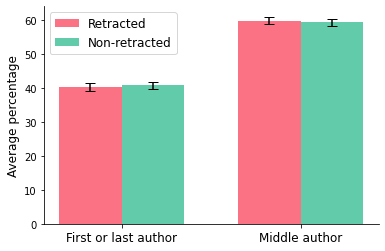

In [18]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
plt.figure(figsize=(10, 6))
fontsize=12

confidence = 0.95
    
# Confidence intervals
ci_data = {}

for col in df.columns[1:5]:  # Ensure columns are correctly iterated
    
    mean = np.mean(df[col])
    
    # These are two points defining an interval
    ci = sms.DescrStatsW(df[col]).tconfint_mean(alpha=1-confidence)

    ci_data[col] = {'mean': mean, 'error': mean-ci[0]}

# Check the keys in ci_data to ensure correct columns
print("ci_data keys:", ci_data.keys())

# Prepare data for plotting
labels = ['First or last author', 'Middle author']
treatment_means = [ci_data['First_Last_Only_Percent_x']['mean'], ci_data['Middle_Percent_x']['mean']]
treatment_errors = [ci_data['First_Last_Only_Percent_x']['error'], ci_data['Middle_Percent_x']['error']]
control_means = [ci_data['First_Last_Only_Percent_y']['mean'], ci_data['Middle_Percent_y']['mean']]
control_errors = [ci_data['First_Last_Only_Percent_y']['error'], ci_data['Middle_Percent_y']['error']]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

color_treatment = '#fb7285'
color_control = '#62ccaa'

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, treatment_means, width, yerr=treatment_errors, color=color_treatment, 
               label='Retracted', capsize=5)
bars2 = ax.bar(x + width/2, control_means, width, yerr=control_errors, color=color_control,
               label='Non-retracted', capsize=5)


# Set background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Hide grid lines
ax.grid(False)
ax.set_ylabel('Average percentage',fontsize=fontsize)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=fontsize)
ax.legend(fontsize=fontsize)

#plt.text(-0.15, 1.05, 'c', transform=plt.gca().transAxes, fontsize=18, fontweight='bold', ha='left')

plt.savefig(OUTDIR+"author_order_analysis_new.pdf", format='pdf')